<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/MNIST%20Variational%20Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generando imágenes con VAEs

### Implementación de un VAE con Keras

In [1]:
#@title **Red codificadora del VAE (encoder)**
from tensorflow import keras
from tensorflow.keras import layers

#Dimensionality of the latent space: a 2D plane
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
#The input image ends up being encoded into these two parameters
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [2]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [3]:
#@title Capa de muestreo del espacio latente

import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        #Draw a batch of random normal vectors
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        #Apply the VAE sampling formula
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [4]:
#@title **Red de decodificación VAE (decoder), mapeo de puntos del espacio latente a imágenes**

#Input where we’ll feed z
latent_inputs = keras.Input(shape=(latent_dim,))
#Produce the same number of coefficients that we had at the level of the Flatten layer in the encoder
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
#Revert the Flatten layer of the encoder
x = layers.Reshape((7, 7, 64))(x)
#Revert the Conv"D layers of the encoder
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
#output shape(28,28,1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [5]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

In [6]:
#@title **Modelo VAE con `train_step()` personalizado**

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        #metrics to keep track of the loss averages over each epoch
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    #list the metrics in the metrics property to enable the model to reset them after each epoch
    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            #sum the reconstruction loss over the spatial dimensions (axes 1 and 2) and take its mean over the batch dimension
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            #Add the regularization term (Kullback–Leibler divergence)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [7]:
#@title **Entrenamiento del VAE**

import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
#train on all MNIST digits: concatenate the training and test samples
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
#no passing a loss argument in compile()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
#no pasing targets in fit
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/30


547/547 [==============================] - 47s 57ms/step - total_loss: 206.3045 - reconstruction_loss: 203.3961 - kl_loss: 2.9080
Epoch 2/30
547/547 [==============================] - 31s 57ms/step - total_loss: 166.1855 - reconstruction_loss: 162.4608 - kl_loss: 3.7246
Epoch 3/30
547/547 [==============================] - 32s 59ms/step - total_loss: 159.7626 - reconstruction_loss: 155.9720 - kl_loss: 3.7906
Epoch 4/30
547/547 [==============================] - 30s 55ms/step - total_loss: 157.0965 - reconstruction_loss: 153.2516 - kl_loss: 3.8449
Epoch 5/30
547/547 [==============================] - 31s 57ms/step - total_loss: 155.3705 - reconstruction_loss: 151.4942 - kl_loss: 3.8763
Epoch 6/30
547/547 [==============================] - 31s 56ms/step - total_loss: 154.1932 - reconstruction_loss: 150.3007 - kl_loss: 3.8925
Epoch 7/30
547/547 [==============================] - 31s 56ms/step - total_loss: 153.1502 - reconstruction_loss: 149.2537 - kl_loss: 3.8965
Epoch 8/30
547/547 [====

1/1 [==============================] - 0s 22ms/step


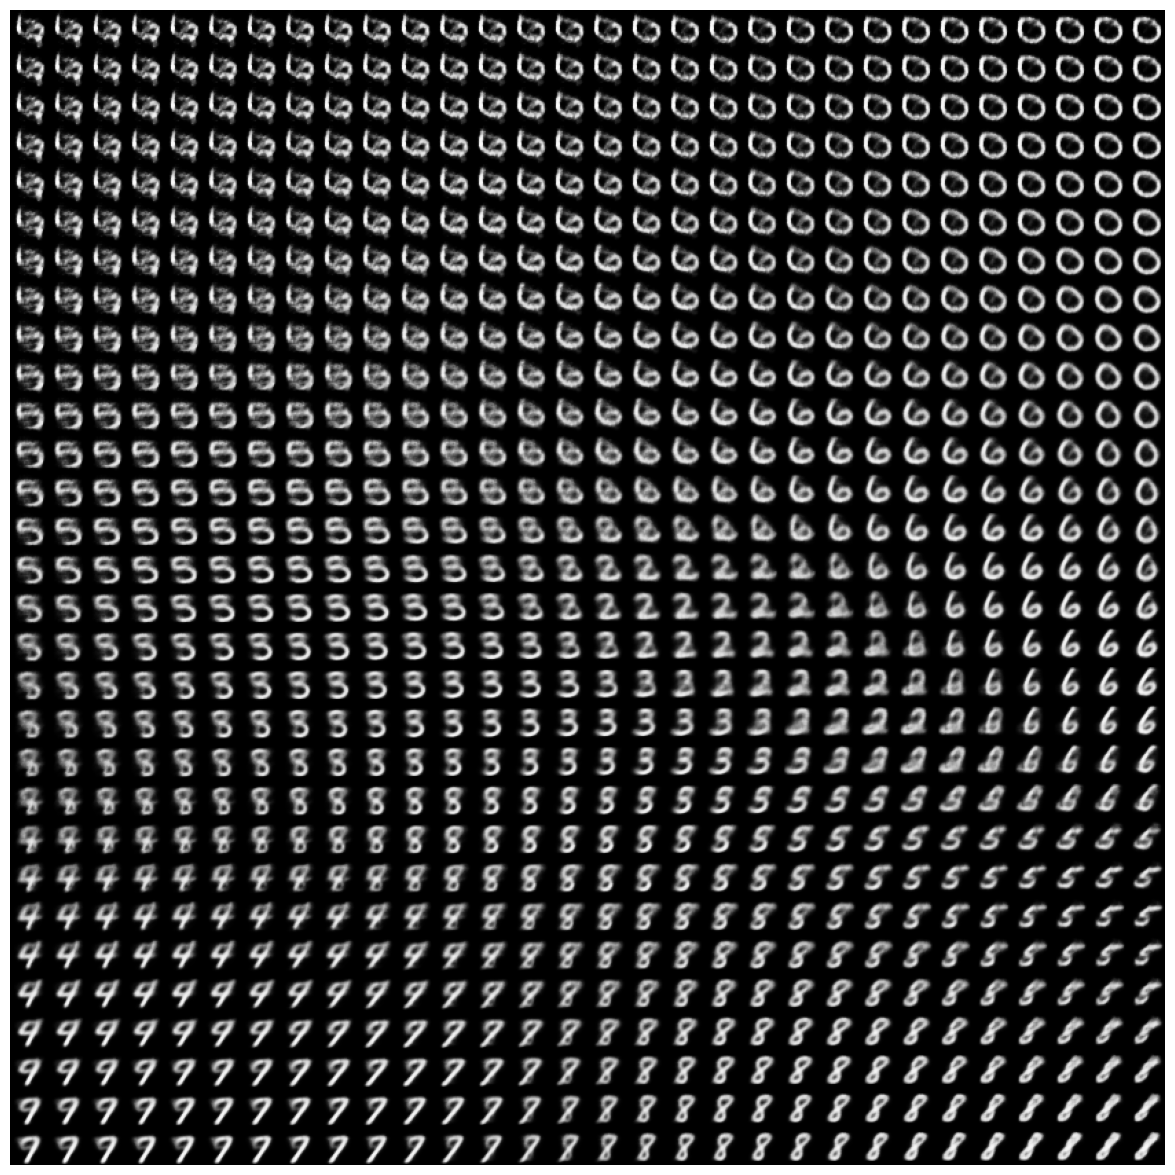

In [8]:
#@title **Muestreo de una rejilla de imágenes desde el espacio 2D latente**

import matplotlib.pyplot as plt

#grid size: 900 digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

#Sample points linearly on a 2D grid
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")